In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.api import OLS

### Чтение данных

In [29]:
import pickle
# v_fact=pickle.load(open('2d_advection_fact.pkl','rb'))
# v_fact=pickle.load(open('2d_advection_fact_2var.pkl','rb'))

path=fr'D:\myProjects\diplom_2\GIT_stencil-net\Experiments\Experiment_2d_thermal_conductivity/'
v_fact=pickle.load(open(path+'v_fact.pkl','rb'))

In [30]:
h=0.1
kurant=0.25
tau=kurant*(h**2)

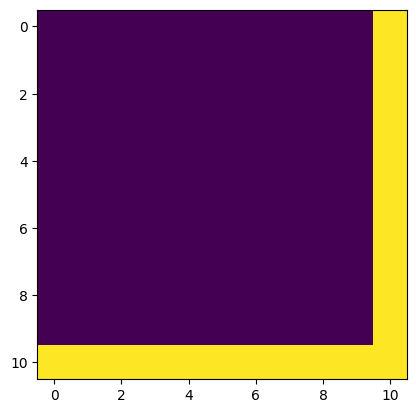

In [31]:
plt.imshow(v_fact[:,:,0])

### Линеаризация

In [32]:
def linearization(v_fact):

    n=len(v_fact)
    A=np.zeros((n*n))

    for i in range(n):
        for j in range(n):
            A[i+n*j]=v_fact[i,j]

    return A

def get_value(A,i,j):

    n=int(np.sqrt(len(A)))
    
    if i>=n and j>=n:
        value = A[i-n+n*j-n]
    elif i>=n:
        value = A[i-n+n*j]
    elif j>=n:
        value = A[i+(n*j)-n]
    else:
        value = A[i+n*j]

    return value


In [33]:
def linearization_inverse(v_fact):

    n=int(np.sqrt(len(v_fact)))
    v_fact_mat=np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            v_fact_mat[i,j]=get_value(v_fact,i,j)

    return v_fact_mat

In [34]:
### test
test_matrix=np.zeros((5,5))
for i in range(5):
    for j in range(5):
        if i==0 or j==0 or i==4 or j==4:
            test_matrix[i,j]=-999
            # test_matrix[i,j]=i+j*4
        else:
            test_matrix[i,j]=i+j*4

test_output=linearization(test_matrix)

for i in range(5):
    for j in range(5):
        assert test_matrix[i,j]==get_value(test_output,i,j),fr'{i},{j} не совпадает'


In [35]:
test_matrix

array([[-999., -999., -999., -999., -999.],
       [-999.,    5.,    9.,   13., -999.],
       [-999.,    6.,   10.,   14., -999.],
       [-999.,    7.,   11.,   15., -999.],
       [-999., -999., -999., -999., -999.]])

In [36]:
test_output

array([-999., -999., -999., -999., -999., -999.,    5.,    6.,    7.,
       -999., -999.,    9.,   10.,   11., -999., -999.,   13.,   14.,
         15., -999., -999., -999., -999., -999., -999.])

In [37]:
linearization_inverse(test_output)

array([[-999., -999., -999., -999., -999.],
       [-999.,    5.,    9.,   13., -999.],
       [-999.,    6.,   10.,   14., -999.],
       [-999.,    7.,   11.,   15., -999.],
       [-999., -999., -999., -999., -999.]])

In [38]:
get_value(test_output,4,4)

np.float64(-999.0)

In [39]:
#ниже определяю функцию
A=make_A(test_output,5)
A.shape

(25, 5)

In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4, include_bias=True)
X_poly = poly.fit_transform(A)
X_poly.shape

(25, 126)

In [41]:
drop_boundary_points(A)

[0, 1, 2, 3, 4, 5, 9, 10, 14, 15, 19, 20, 21, 22, 23, 24]

In [42]:
filtered_arr = np.delete(A, drop_boundary_points(A), axis=0)  # axis=0 — удаляем строки
filtered_arr

array([[   5., -999.,    9., -999.,    6.],
       [   6., -999.,   10.,    5.,    7.],
       [   7., -999.,   11.,    6., -999.],
       [   9.,    5.,   13., -999.,   10.],
       [  10.,    6.,   14.,    9.,   11.],
       [  11.,    7.,   15.,   10., -999.],
       [  13.,    9., -999., -999.,   14.],
       [  14.,   10., -999.,   13.,   15.],
       [  15.,   11., -999.,   14., -999.]])

In [43]:
# B_mat=make_B(test_output,5)
# B_mat = poly.fit_transform(B_mat)
# B_mat.shape

In [44]:
# np.concatenate([A,B_mat],axis=1).shape

### ПреПроцесс конечно-разн аналогии

In [45]:
def make_A(u_0,n):

    n2=5
    # n2=7

    A=np.zeros((n*n,n2))
    # conv coeffs
    for i in range(0,n):
        for j in range(0,n):
            ind=i+j*(n)
            
            # Величины 1-й степени
            A[ind][0]=get_value(u_0,i,j)
            A[ind][1]=get_value(u_0,i,j-1)
            A[ind][2]=get_value(u_0,i,j+1)
            A[ind][3]=get_value(u_0,i-1,j)
            A[ind][4]=get_value(u_0,i+1,j)

            # A[ind][5]=get_value(u_0,i,j-2)
            # A[ind][6]=get_value(u_0,i-2,j)
            # A[ind][7]=get_value(u_0,i,j+2)
            # A[ind][8]=get_value(u_0,i+2,j)

    return A

# def make_B(u_0,n):

#     # n2=2

#     n2=0

#     A=np.zeros((n*n,n2))
#     # conv coeffs
#     for i in range(0,n):
#         for j in range(0,n):
#             ind=i+j*(n)
            
#             # Величины 1-й степени
#             # A[ind][0]=get_value(u_0,i+1,j+1)
#             # A[ind][1]=get_value(u_0,i-1,j-1)

#             # A[ind][0]=get_value(u_0,i+2,j+2)
#             # A[ind][2]=get_value(u_0,i-2,j-2)

#     return A

def drop_boundary_points(A_mat):

    A=A_mat.copy()

    n=int(np.sqrt(len(A)))
    
    boundary_id=[i+j*n for i in range(n) for j in range(n) if i==0 or j==0 or i==n-1 or j==n-1]

    return sorted(boundary_id)

def make_rhs(t_0,t_1,n,tau):
    
    rhs=np.zeros((n*n,1))
    
    for i in range(0,n):
        for j in range(0,n):
            rhs[i+j*n][0]=(get_value(t_1,i,j)-get_value(t_0,i,j))/tau

    return rhs

### Конечно-разн аналогия

In [46]:
v_fact.shape[0]

11

In [47]:
# n_cycle = v_fact.shape[0]-1
n_cycle=40

coeffs_lst=[]
mse_lst=[]
for j in range(n_cycle):
    
    u_0=v_fact[:,:,j]
    u_1=v_fact[:,:,j+1]
    n=11

    u_0=linearization(u_0) # начальное состояние
    u_1=linearization(u_1) # следующее состояние

    A_mat=make_A(u_0,n)
    # poly = PolynomialFeatures(degree=2, include_bias=True)
    # A_mat = poly.fit_transform(A_mat)

    # B_mat=make_B(u_0,n)
    # poly = PolynomialFeatures(degree=2, include_bias=False)
    # B_mat = poly.fit_transform(B_mat)

    # A_mat=np.concatenate([A_mat,B_mat],axis=1)

    rhs=make_rhs(u_0,u_1,n,tau=tau)

    print(A_mat.shape,rhs.shape)

    S = A_mat
    rhs = rhs
    S=np.delete(A_mat, drop_boundary_points(A_mat), axis=0) 
    rhs=np.delete(rhs,drop_boundary_points(rhs), axis=0)

    print(S.shape,rhs.shape)
    
    model_sm=OLS(rhs,S,hasconst=True)
    results_sm=model_sm.fit()
    
    mse=mean_squared_error(rhs,results_sm.predict(S))
    # print("MSE :",mse)
    
    # print('COEFFICIENT',results_sm.params)
    mse_lst.append(mse)
    coeffs_lst.append(results_sm.params)
    
mse_lst=np.array(mse_lst)
coeffs_lst=np.array(coeffs_lst)

(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121, 1)
(81, 5) (81, 1)
(121, 5) (121,

(-1.0, 1.0)

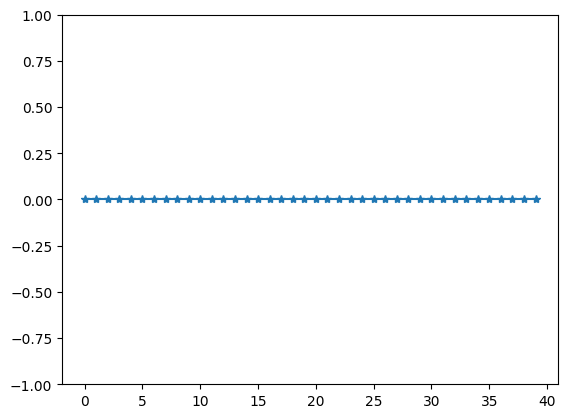

In [48]:
plt.plot(mse_lst,'-*')
plt.ylim([-1,1])

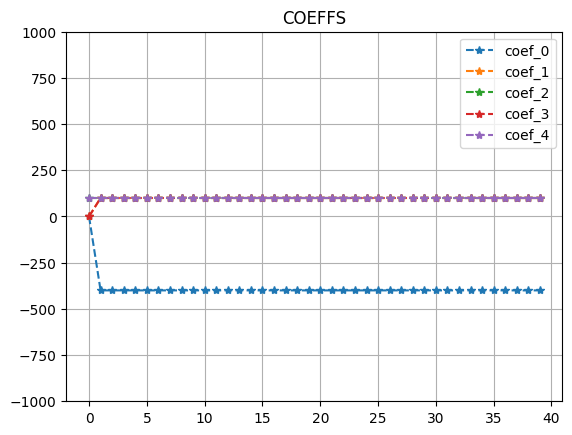

In [49]:
plt.figure()
for j in range(len(coeffs_lst[0,:])):
    plt.plot(coeffs_lst[:,j],'--*',label=fr'coef_{j}')
plt.ylim([-1000,1000])
plt.title('COEFFS')
plt.legend()
plt.grid()

In [50]:
coeffs_lst[-1]

array([-400.,  100.,  100.,  100.,  100.])

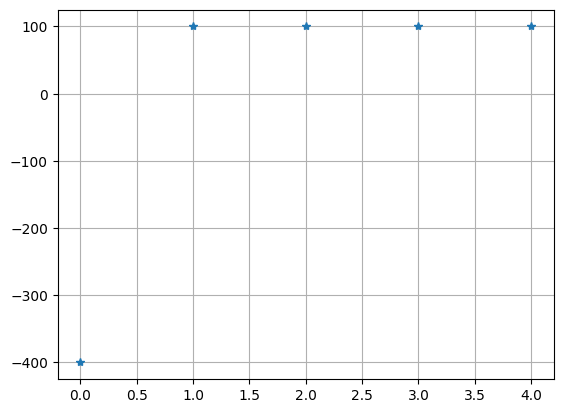

In [51]:
plt.plot(pd.Series(coeffs_lst[-1]).sort_values(),'*')
plt.grid()

(121, 5) (121, 1)


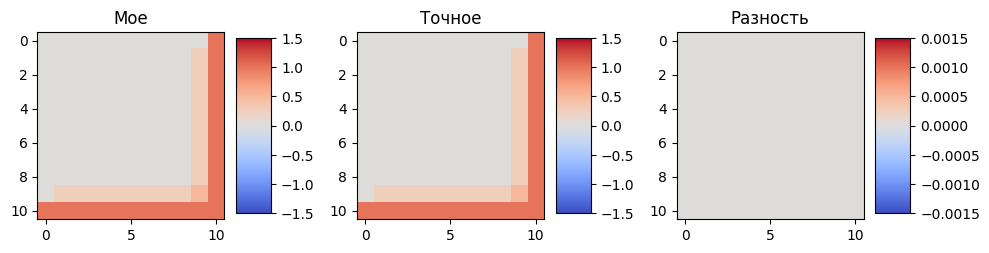

(121, 5) (121, 1)


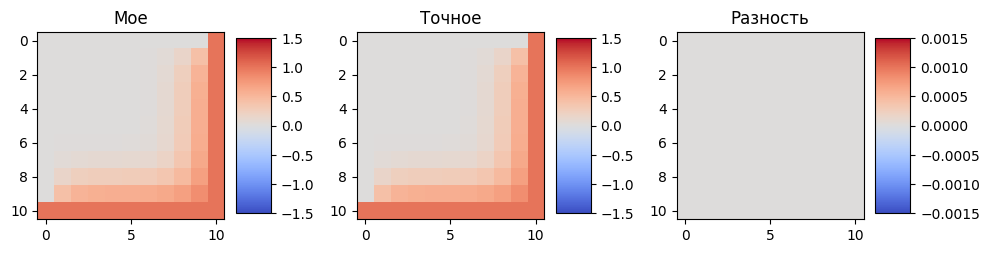

(121, 5) (121, 1)


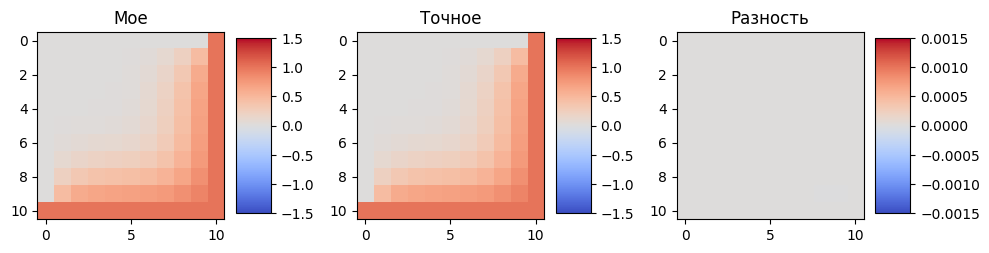

(121, 5) (121, 1)


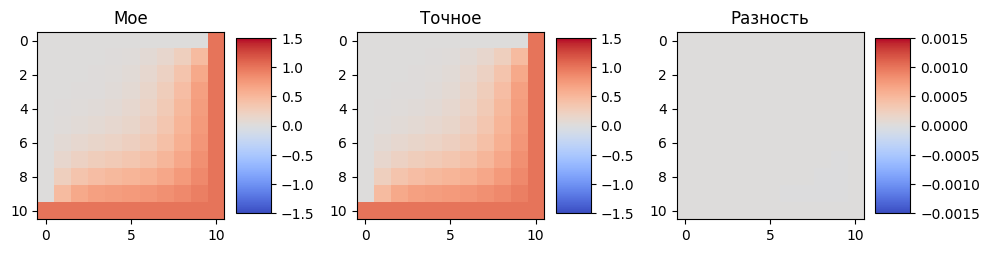

(121, 5) (121, 1)


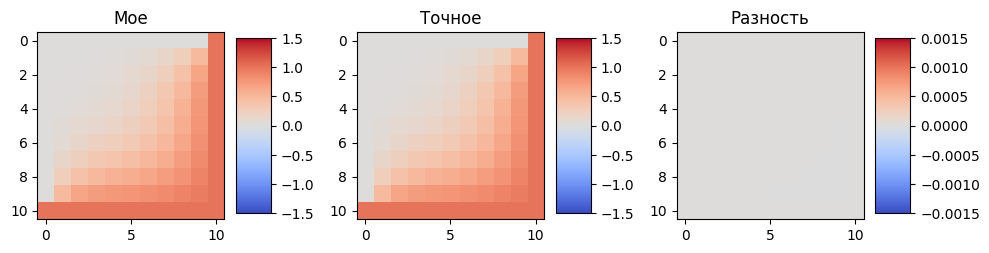

(121, 5) (121, 1)


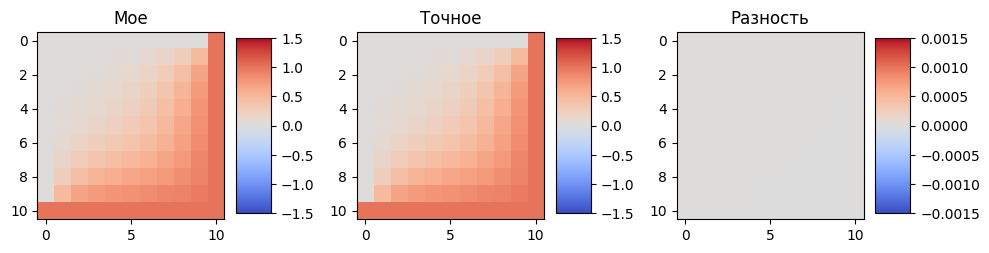

(121, 5) (121, 1)


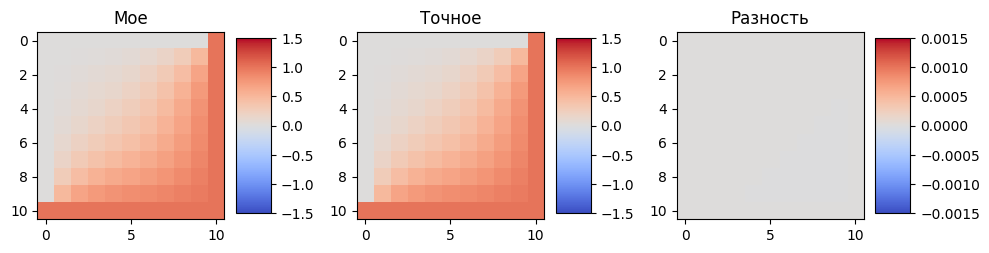

(121, 5) (121, 1)


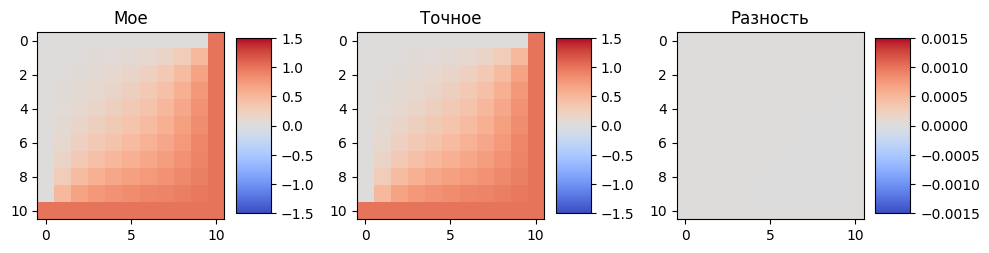

In [53]:
for j in range(0,n_cycle,5):
    
    u_0=v_fact[:,:,j]
    u_1=v_fact[:,:,j+1]
    n=11

    u_0=linearization(u_0) # начальное состояние
    u_1=linearization(u_1) # следующее состояние

    A_mat=make_A(u_0,n)
    # poly = PolynomialFeatures(degree=2, include_bias=True)
    # A_mat = poly.fit_transform(A_mat)

    # B_mat=make_B(u_0,n)
    # poly = PolynomialFeatures(degree=2, include_bias=False)
    # B_mat = poly.fit_transform(B_mat)

    # A_mat=np.concatenate([A_mat,B_mat],axis=1)
    
    rhs=make_rhs(u_0,u_1,n,tau=tau)

    print(A_mat.shape,rhs.shape)

    S = A_mat
    rhs = rhs

    logit_sol=np.dot(S,coeffs_lst[-1])*tau
    logit_sol[drop_boundary_points(logit_sol)]=0

    vmin=-1.5
    vmax=1.5

    plt.figure(figsize=(10, 9))
    plt.subplot(1,3,1)
    img1=plt.imshow(linearization_inverse(logit_sol+u_0),vmin=vmin,vmax=vmax,
               label='logit_sol',
               cmap='coolwarm')
    plt.title('Мое')
    cbar=plt.colorbar(img1,aspect=5)

    plt.subplot(1,3,2)
    img2=plt.imshow(linearization_inverse(u_1),vmin=vmin,vmax=vmax,
               label='logit_sol',
               cmap='coolwarm')
    plt.title('Точное')
    plt.colorbar(img2,aspect=5)

    plt.subplot(1,3,3)
    img3=plt.imshow(linearization_inverse(u_1)-linearization_inverse(logit_sol+u_0),
                    vmin=vmin/1000,vmax=vmax/1000,
               label='logit_sol',
               cmap='coolwarm')
    plt.title('Разность')
    plt.colorbar(img3,aspect=5)

    plt.tight_layout()  # Чтобы избежать наложения подписей
    plt.show()

In [26]:
logit_sol.shape

(121,)

In [27]:
coef_name=['u_i_j','u_i_j-1','u_i_j+1','u_i-1_j','u_i+1_j']
true_coeffs=[-4/h**2,1/h**2,1/h**2,1/h**2,1/h**2]

pd.DataFrame({'coef_name':coef_name,
              'true':true_coeffs,
              'OLS':coeffs_lst[-1]})

,coef_name,true,OLS
0,u_i_j,-400.0,-400.0
1,u_i_j-1,100.0,100.0
2,u_i_j+1,100.0,100.0
3,u_i-1_j,100.0,100.0
4,u_i+1_j,100.0,100.0
